In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr

from scipy.stats import norm

import isolearn.io as isoio

from analyze_leslie_apadb_celltypes_helpers import *


In [2]:
#Load Leslie/APADB data
leslie_tissue_index = np.array(['hek293', 'mcf10a_hras2', 'mcf10a1', 'mcf10a2', 'mcf10a_hras1', 'bcells1', 'mcf7', 'bcells2', 'ovary', 'breast', 'brain', 'skmuscle', 'blcl', 'hES', 'testis', 'hela', 'ntera'], dtype=np.object)
apadb_tissue_index = np.array(['kidney', 'pancreas', 'monocytes', 'all', 'pdac', 'prcc', 'full_blood', 'hlf'], dtype=np.object)

#Load PAS dataframe and cut matrix
native_dict = isoio.load('../data/prepared_data/apa_leslie_apadb_data/apa_leslie_apadb_data')

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned_padded'
pred_dict = isoio.load('predictions/apa_leslie_apadb_data/' + model_name + '_predictions')

#Join measurements with predictions
df, leslie_isoform_count, apadb_isoform_count, leslie_cleavage_count_dict, leslie_cleavage_prob_dict, pred_cleavage_prob = join_pas_dataframes(native_dict, pred_dict, leslie_tissue_index, apadb_tissue_index)

#Load Leslie/APADB pairwise APA dataframe
pair_dict = isoio.load('../data/prepared_data/apa_leslie_apadb_pair_data/apa_leslie_apadb_pair_data')

#Load predictions
model_name = 'aparent_apadb_fitted_legacy_pasaligned_padded'
pair_pred_dict = isoio.load('predictions/apa_leslie_apadb_pair_data/' + model_name + '_predictions')

#Join measurements with predictions
pair_df, leslie_cleavage_count_prox_dict, leslie_cleavage_prob_prox_dict, leslie_cleavage_count_dist_dict, leslie_cleavage_prob_dist_dict, pred_cleavage_prob_prox, pred_cleavage_prob_dist = join_apa_dataframes(pair_dict, pair_pred_dict, leslie_tissue_index, apadb_tissue_index)

#Join individual PAS sequence predictions onto pairwise APA dataframe
pair_df, leslie_cleavage_count_prox_dict, leslie_cleavage_prob_prox_dict, leslie_cleavage_count_dist_dict, leslie_cleavage_prob_dist_dict, pred_cleavage_prob_prox, pred_cleavage_prob_dist = join_apa_dataframe_individual_site_predictions(df, pred_cleavage_prob, pair_df, leslie_cleavage_count_prox_dict, leslie_cleavage_prob_prox_dict, leslie_cleavage_count_dist_dict, leslie_cleavage_prob_dist_dict, pred_cleavage_prob_prox, pred_cleavage_prob_dist)


In [3]:
#Start of multiplex evaluation of cell type-specific prediction performance

site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
min_total_apadb_count = 10
min_total_leslie_count = 10
max_cut_region = 60
min_distance = 40
max_distance = 4000
only_differentials = False

apadb_total_count_col = 'apadb_total_count_pooled'
leslie_total_count_col = 'leslie_total_count_apadb_region_pooled'

#Apply global pre-filters
df_to_use = pair_df.query(apadb_total_count_col + " >= " + str(min_total_apadb_count))
df_to_use = df_to_use.query(leslie_total_count_col + " >= " + str(min_total_leslie_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]
if only_differentials :
    df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")
df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

df_to_use = df_to_use.query("mirna_prox == mirna_dist")

#Shuffle dataframe
shuffle_index = np.arange(len(df_to_use))
np.random.shuffle(shuffle_index)

df_all = df_to_use.iloc[shuffle_index].copy().reset_index(drop=True)

print('Total size = ' + str(len(df_all)))

#Split into training and test data
train_set_frac = 0.5

df_train = df_all.iloc[:int(len(df_all) * train_set_frac)]
df_test = df_all.iloc[len(df_train):]

print('Train size = ' + str(len(df_train)))
print('Test size = ' + str(len(df_test)))


Total size = 15912
Train size = 7956
Test size = 7956


In [4]:
#Initialize results dict
tissue_results_dict = {}

#Initialize cell type-specific min count filters
count_filters = {
    'apadb_pooled' : 1000,
    'apadb_kidney' : 20,
    'apadb_pancreas' : 10,
    'apadb_monocytes' : 20,
    'apadb_all' : 20,
    'apadb_pdac' : 20,
    'apadb_prcc' : 20,
    'apadb_full_blood' : 500,
    'apadb_hlf' : 500,
    
    'leslie_pooled' : 1000,
    'leslie_hek293' : 50,
    'leslie_mcf10a_hras2' : 50,
    'leslie_mcf10a1' : 50,
    'leslie_mcf10a2' : 50,
    'leslie_mcf10a_hras1' : 50,
    'leslie_bcells1' : 50,
    'leslie_mcf7' : 50,
    'leslie_bcells2' : 50,
    'leslie_ovary' : 50,
    'leslie_breast' : 50,
    'leslie_brain' : 50,
    'leslie_skmuscle' : 50,
    'leslie_blcl' : 50,
    'leslie_hES' : 50,
    'leslie_testis' : 50,
    'leslie_hela' : 50,
    'leslie_ntera' : 50
}


In [5]:
#Fit on APADB pooled, predict on everything

for only_differentials, predictor_suffix in [(False, ''), (True, '_differential')] :
    X_apadb, y_ratio_apadb, y_logodds_apadb, count_apadb, df_apadb = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=only_differentials)
    X_apadb_train, y_ratio_apadb_train, y_logodds_apadb_train, count_apadb_train, df_apadb_train = get_data(df_train, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=only_differentials)
    X_apadb_test, y_ratio_apadb_test, y_logodds_apadb_test, count_apadb_test, df_apadb_test = get_data(df_test, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=only_differentials)


    y_logodds_apadb_test_hat, _, _, _, w_bundle_linear_train = fit_linear_model(X_apadb_train, y_logodds_apadb_train, X_apadb_test, y_logodds_apadb_test, l2_lambda=None, l1_lambda=None)
    w_linear_train, w_linear_0_train = w_bundle_linear_train

    y_ratio_apadb_test_hat, _, _, _, w_bundle_logistic_train = fit_logistic_model(X_apadb_train, y_ratio_apadb_train, X_apadb_test, y_ratio_apadb_test, l2_lambda=0.0)
    w_logistic_train, w_logistic_0_train = w_bundle_logistic_train


    _, y_logodds_apadb_hat = k_fold_cross_linear(50, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)

    _, y_ratio_apadb_hat = k_fold_cross_logistic(50, X_apadb, y_ratio_apadb, l2_lambda=0.0)

    tissue_results_dict['apadb_pooled' + predictor_suffix] = {}
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled'] = {}
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_logodds'] = y_logodds_apadb
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_ratio'] = y_ratio_apadb
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_logodds_hat'] = y_logodds_apadb_hat
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_ratio_hat'] = y_ratio_apadb_hat
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_logodds_test'] = y_logodds_apadb_test
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_ratio_test'] = y_ratio_apadb_test
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_logodds_test_hat'] = y_logodds_apadb_test_hat
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_ratio_test_hat'] = y_ratio_apadb_test_hat
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_count'] = count_apadb
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['y_count_test'] = count_apadb_test
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['df'] = df_apadb
    tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_pooled']['df_test'] = df_apadb_test

    for tissue in apadb_tissue_index :

        X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=only_differentials)
        X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=only_differentials)

        y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)

        y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue] = {}
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['y_count'] = count_tissue
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['y_count_test'] = count_tissue_test
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['df'] = df_tissue
        tissue_results_dict['apadb_pooled' + predictor_suffix]['apadb_' + tissue]['df_test'] = df_tissue_test

    for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :

        X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=only_differentials)
        X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=only_differentials)

        y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)

        y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue] = {}
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['y_count'] = count_tissue
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['y_count_test'] = count_tissue_test
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['df'] = df_tissue
        tissue_results_dict['apadb_pooled' + predictor_suffix]['leslie_' + tissue]['df_test'] = df_tissue_test


In [6]:
#Fit and predict on individual tissues

for only_differentials, predictor_suffix in [(False, ''), (True, '_differential')] :
    for tissue in apadb_tissue_index :

        X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=only_differentials)
        X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=only_differentials)
        X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=only_differentials)

        if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
            continue

        y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

        y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

        _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

        _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

        tissue_results_dict['apadb_' + tissue + predictor_suffix] = {}
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue] = {}
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_count'] = count_tissue
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['y_count_test'] = count_tissue_test
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['df'] = df_tissue
        tissue_results_dict['apadb_' + tissue + predictor_suffix]['apadb_' + tissue]['df_test'] = df_tissue_test

    for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :

        X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=only_differentials)
        X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=only_differentials)
        X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=only_differentials)

        if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
            continue

        y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

        y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

        _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

        _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

        tissue_results_dict['leslie_' + tissue + predictor_suffix] = {}
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue] = {}
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_count'] = count_tissue
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['y_count_test'] = count_tissue_test
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['df'] = df_tissue
        tissue_results_dict['leslie_' + tissue + predictor_suffix]['leslie_' + tissue]['df_test'] = df_tissue_test


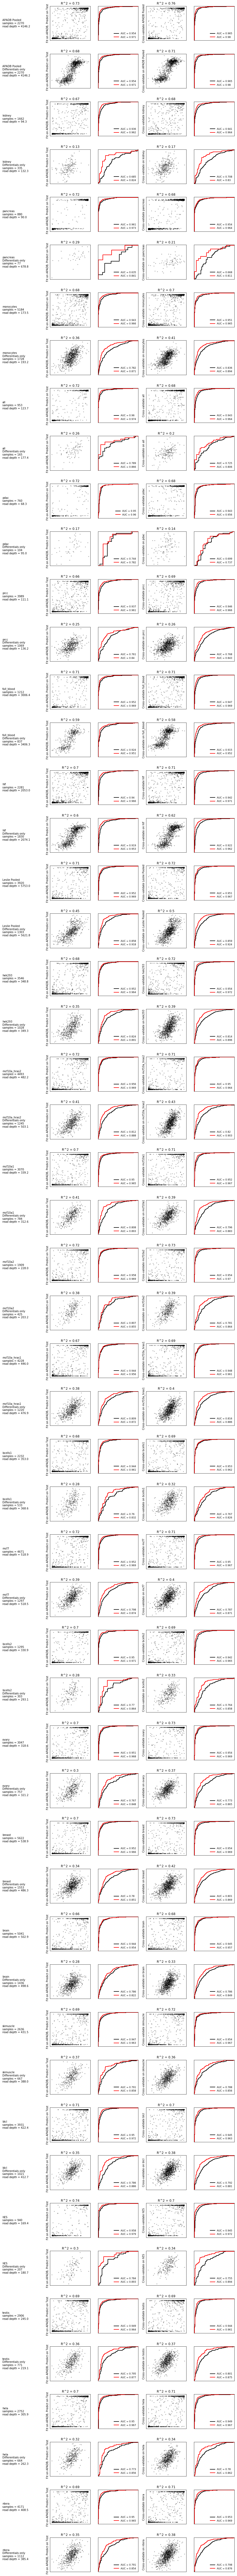

In [21]:
#Plot multiplex cell-type specific results

max_n_members = 1000
show_used_sample_stats_only = False

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    combined_tissue_index.append('leslie_' + tissue)


n_rows = 2 * len(combined_tissue_index)
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))

n_samples_tissues = []
read_depth_tissues = []
r2_tissues = []
auc_tissues = []
roc_tissues = []

n_samples_tissues_diff = []
read_depth_tissues_diff = []
r2_tissues_diff = []
auc_tissues_diff = []
roc_tissues_diff = []

kept_combined_tissue_index = []
min_samples_for_summary = 1
min_read_depth_for_summary = 1
min_samples_diff_for_summary = 100
min_read_depth_diff_for_summary = 100

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    n_samples = len(tissue_results_dict[tissue][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict[tissue][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict[tissue + '_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict[tissue + '_differential'][tissue]['y_count']), 1)
    
    plt.sca(ax[2 * tissue_i, 0])
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.sca(ax[2 * tissue_i + 1, 0])
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        n_samples_used, avg_reads_used, _, _, _, _, _ = plot_tissue_result('Fit on APADB, Predict on Test', tissue_results, ax[2 * tissue_i, 1], ax[2 * tissue_i, 2], max_n_members, use_test=True, use_logodds=False)
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        _, _, r2, auc, roc, auc_highconf, roc_highconf = plot_tissue_result('Cross-validate ' + tissue_name, tissue_results, ax[2 * tissue_i, 3], ax[2 * tissue_i, 4], max_n_members, use_test=False, use_logodds=False)
        
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        n_samples_used, avg_reads_used, _, _, _, _, _ = plot_tissue_result('Fit on APADB, Predict on Test', tissue_results, ax[2 * tissue_i + 1, 1], ax[2 * tissue_i + 1, 2], max_n_members, use_test=True, use_logodds=True)
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        _, _, r2_diff, auc_diff, roc_diff, auc_diff_highconf, roc_diff_highconf = plot_tissue_result('Cross-validate on ' + tissue_name, tissue_results, ax[2 * tissue_i + 1, 3], ax[2 * tissue_i + 1, 4], max_n_members, use_test=False, use_logodds=True)
    
    
    if n_samples >= min_samples_for_summary and n_samples_diff >= min_samples_diff_for_summary and avg_reads >= min_read_depth_for_summary and avg_reads_diff >= min_read_depth_diff_for_summary :
        kept_combined_tissue_index.append(tissue)
        r2_tissues.append(r2)
        auc_tissues.append(auc_highconf)
        roc_tissues.append(roc_highconf)
        n_samples_tissues.append(n_samples)
        read_depth_tissues.append(avg_reads)

        r2_tissues_diff.append(r2_diff)
        auc_tissues_diff.append(auc_diff_highconf)
        roc_tissues_diff.append(roc_diff_highconf)
        n_samples_tissues_diff.append(n_samples_diff)
        read_depth_tissues_diff.append(avg_reads_diff)
    
    #Annotate row
    annot_text = tissue_name + '\n'
    annot_text += 'samples = ' + str(n_samples) + '\n'
    annot_text += 'read depth = ' + str(round(avg_reads, 2))
    ax[2 * tissue_i, 0].text(0.01, 0.5, annot_text, verticalalignment='center', horizontalalignment='left', transform=ax[2 * tissue_i, 0].transAxes, fontsize=10)
    
    annot_text = tissue_name + '\n'
    annot_text += 'Differentials only\n'
    annot_text += 'samples = ' + str(n_samples_diff) + '\n'
    annot_text += 'read depth = ' + str(round(avg_reads_diff, 2))
    ax[2 * tissue_i + 1, 0].text(0.01, 0.5, annot_text, verticalalignment='center', horizontalalignment='left', transform=ax[2 * tissue_i + 1, 0].transAxes, fontsize=10)


plt.tight_layout()
plt.show()


Number of APA Sites and Mean Read Depth.


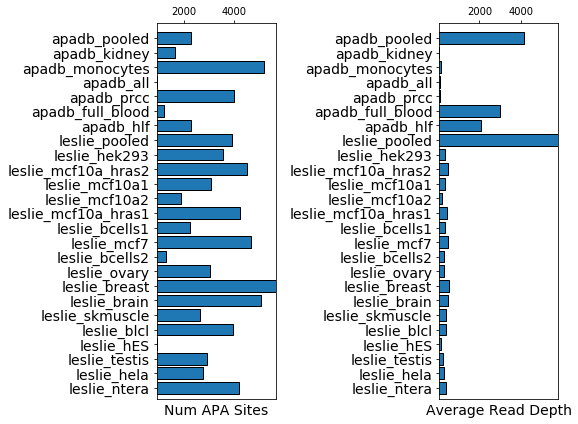

Cross-Validated Isoform Proportion R^2 and Preferential Usage AUC.


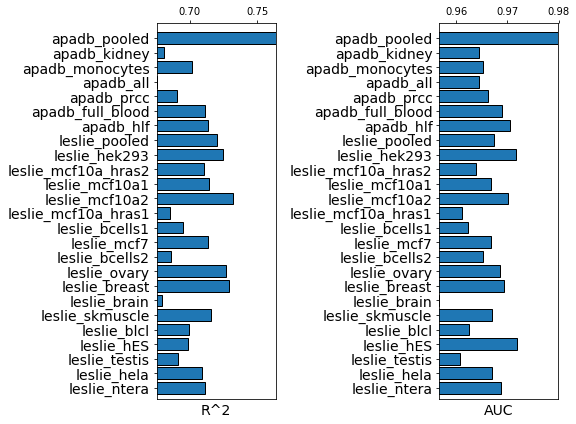

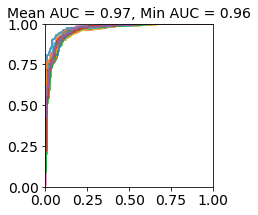

In [23]:
print('Number of APA Sites and Mean Read Depth.')

plot_performance_double_bar(kept_combined_tissue_index, n_samples_tissues, read_depth_tissues, measure_1_label='Num APA Sites', measure_2_label='Average Read Depth')

print('Cross-Validated Isoform Proportion R^2 and Preferential Usage AUC.')

plot_performance_double_bar(kept_combined_tissue_index, r2_tissues, auc_tissues, measure_1_label='R^2', measure_2_label='AUC')

#Plot ROCs
f = plt.figure(figsize=(3, 3))
for tissue_i, tissue in enumerate(kept_combined_tissue_index) :
    fpr, tpr = roc_tissues[tissue_i]
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75)

min_auc = np.min(auc_tissues)
mean_auc = np.mean(auc_tissues)
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)), fontsize=14)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.show()


Number of APA Sites and Mean Read Depth (Only pairs where both sites are used).


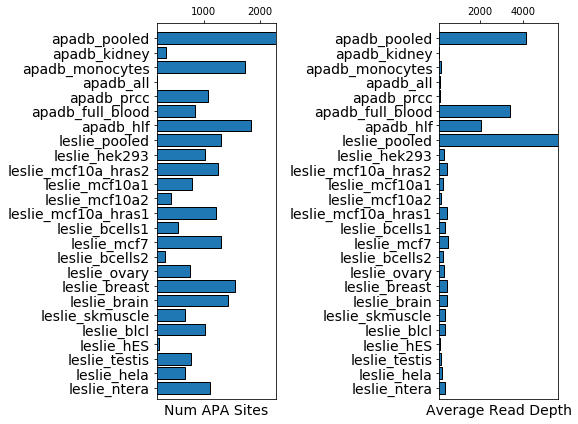

Cross-Validated Isoform Log Odds R^2 and Preferential Usage AUC (Only pairs where both sites are used).


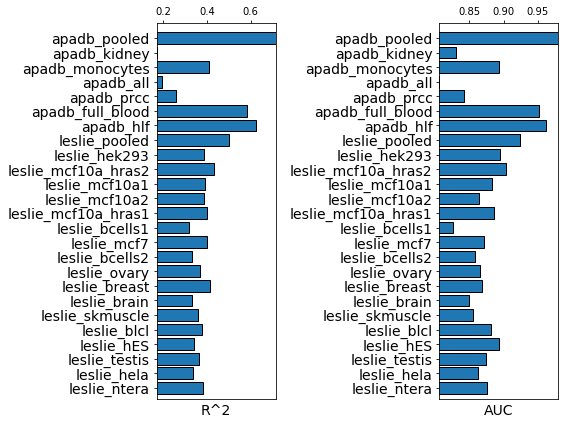

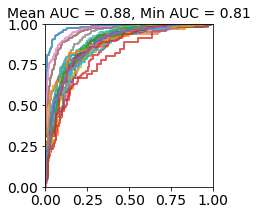

In [24]:
print('Number of APA Sites and Mean Read Depth (Only pairs where both sites are used).')

plot_performance_double_bar(kept_combined_tissue_index, n_samples_tissues_diff, read_depth_tissues_diff, measure_1_label='Num APA Sites', measure_2_label='Average Read Depth')

print('Cross-Validated Isoform Log Odds R^2 and Preferential Usage AUC (Only pairs where both sites are used).')

plot_performance_double_bar(kept_combined_tissue_index, r2_tissues_diff, auc_tissues_diff, measure_1_label='R^2', measure_2_label='AUC')

#Plot ROCs
f = plt.figure(figsize=(3, 3))
for tissue_i, tissue in enumerate(kept_combined_tissue_index) :
    fpr, tpr = roc_tissues_diff[tissue_i]
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75)

min_auc = np.min(auc_tissues_diff)
mean_auc = np.mean(auc_tissues_diff)
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)), fontsize=14)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.show()
